In [1]:
import pandas as pd
import numpy as np
import os
import time
import pickle
import json
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
# !pip install yfinance

In [2]:
cwd = os.getcwd()

# Create dataframe of all HF filing summary

In [3]:
def create_funds_df(cik):
    """
    Check if cik is already in the funds df - it will help us when adding ciks to the list.
    """
    if os.path.isfile('Data/funds_df.csv'):
        df_to_check_in = pd.read_csv('Data/funds_df.csv')
        ciks_in_df = list(df_to_check_in.CIK.astype('str').unique())
        if cik in ciks_in_df:
            return False
        
    """
    Find fund's df_HF and stocks_df files
    """
    path = cwd+f'/Data/{cik}'
    initial_df_file = path + f'/{cik}_df_HF.csv'
    initial_df = pd.read_csv(initial_df_file, index_col=0)
    stocks_df_file = path + f'/{cik}_stocks_df.csv'
    stocks_df = pd.read_csv(stocks_df_file, index_col=0)
    
    """
    create funds_df
    """
    funds_df = initial_df.groupby(['CIK', 'periodOfReport']).agg({'value': 'sum', 'nameOfIssuer': 'count'})
    funds_df = funds_df.reset_index()
    funds_df = funds_df.rename(columns={'value': 'AUM', 'nameOfIssuer': 'positionsNumber'})
    funds_df['AUM'] = funds_df['AUM'] 
    
    new_columns = ['count_new', 'sum_new', 'count_added_to', 'sum_added_to', 'count_trimmed', 'sum_trimmed',
                   'count_sold_out', 'sum_sold_out', 'bought', 'sold', 'holdings_replacement', 
                   'portfolio_turnover', 'portfolio_duration', 'top_10_holdings', 'yield_from_last_report', 
                   'yield_from_1_year', 'yield_from_3_year']
    for column in new_columns:
        funds_df[column] = 0
        
    """
    calculate portfolio_duration
    """
    protfolio_duration_by_Q = stocks_df.loc[stocks_df.portfolio_duration > 0].groupby(['CIK', 'report_date'])['portfolio_duration'].agg('mean')
    protfolio_duration_by_Q = protfolio_duration_by_Q.reset_index()
    protfolio_duration_by_Q = protfolio_duration_by_Q.rename(columns={'report_date': 'periodOfReport'})
    funds_df.portfolio_duration = round(protfolio_duration_by_Q.portfolio_duration[protfolio_duration_by_Q.periodOfReport == funds_df.periodOfReport], 3)
    
    
    """
    pivot(sum) on stocks_df by Q
    """
    stocks_df_by_Q = pd.pivot_table(stocks_df, index=['CIK', 'report_date'],
                                    values=['New', 'AddedTo', 'Trimmed', 'SoldOut'],
                                    aggfunc='sum')
    stocks_df_by_Q = stocks_df_by_Q.reset_index()
    stocks_df_by_Q = stocks_df_by_Q.rename(columns={'report_date': 'periodOfReport'})
    
    """
    from pivot(sum) to funds columns
    """
    funds_df.sum_new = stocks_df_by_Q.New[stocks_df_by_Q.periodOfReport == funds_df.periodOfReport]
    funds_df.sum_added_to = round(stocks_df_by_Q.AddedTo[stocks_df_by_Q.periodOfReport == funds_df.periodOfReport], 2)
    funds_df.sum_trimmed = round(stocks_df_by_Q.Trimmed[stocks_df_by_Q.periodOfReport == funds_df.periodOfReport], 2)
    funds_df.sum_sold_out = stocks_df_by_Q.SoldOut[stocks_df_by_Q.periodOfReport == funds_df.periodOfReport]
#     funds_df.portfolio_duration = round(stocks_df_by_Q.portfolio_duration[stocks_df_by_Q.periodOfReport == funds_df.periodOfReport], 2)

    
    """
    pivot(count) on stocks_df by Q
    """
    counts_table = pd.pivot_table(stocks_df, index=['CIK', 'report_date'], 
                                  values=['New', 'AddedTo', 'Trimmed', 'SoldOut'],
                                  aggfunc= lambda x: (x>0).sum())
    counts_table = counts_table.reset_index()
    counts_table = counts_table.rename(columns={'report_date': 'periodOfReport'})
    
    """
    from pivot(count) to funds columns
    """
    funds_df.count_added_to = counts_table.AddedTo[counts_table.periodOfReport == funds_df.periodOfReport]
    funds_df.count_trimmed = counts_table.Trimmed[counts_table.periodOfReport == funds_df.periodOfReport]
    funds_df.count_new = counts_table.New[counts_table.periodOfReport == funds_df.periodOfReport]
    funds_df.count_sold_out = counts_table.SoldOut[counts_table.periodOfReport == funds_df.periodOfReport]
    
    """
    calculate bought and sold
    """
    funds_df.bought = round(funds_df.sum_new + funds_df.sum_added_to, 2)
    funds_df.sold = round(funds_df.sum_sold_out + funds_df.sum_trimmed, 2)
    funds_df.holdings_replacement = funds_df[['bought','sold']].min(axis=1)
    
    """
    calculate portfolio_turnover
    """
    for i in range(1, len(funds_df)):
        if funds_df.loc[i, 'AUM'] + funds_df.loc[i-1, 'AUM'] > 0:
            funds_df.loc[i, 'portfolio_turnover'] = round(funds_df.loc[i, 'holdings_replacement'] / ((funds_df.loc[i, 'AUM'] + funds_df.loc[i-1, 'AUM'])/2), 2)
            
    """
    funds' Yield
    """ 
    for i in range(1, len(funds_df)):
        funds_df.loc[len(funds_df)-i, 'yield_from_last_report'] = round((funds_df.loc[len(funds_df)-i, 'AUM']-funds_df.loc[len(funds_df)-i, 'bought']+funds_df.loc[len(funds_df)-i, 'sold'])/funds_df.loc[len(funds_df)-i-1, 'AUM']-1, 2)


    for i in range(1, len(funds_df)):
        if len(funds_df)-i-4 > 0:
            funds_df.loc[len(funds_df)-i, 'yield_from_1_year'] = round((funds_df.loc[len(funds_df)-i, 'AUM']-funds_df.loc[len(funds_df)-i, 'bought']+funds_df.loc[len(funds_df)-i, 'sold'])/funds_df.loc[len(funds_df)-i-4, 'AUM']-1, 2)


    for i in range(1, len(funds_df)):
        if len(funds_df)-i-12 > 0:
            funds_df.loc[len(funds_df)-i, 'yield_from_3_year'] = round((funds_df.loc[len(funds_df)-i, 'AUM']-funds_df.loc[len(funds_df)-i, 'bought']+funds_df.loc[len(funds_df)-i, 'sold'])/funds_df.loc[len(funds_df)-i-12, 'AUM']-1, 2)

    """
    top 10 holdings
    """
    top10_holding = stocks_df.groupby('report_date')['holding_proportion'].nlargest(10).sum(level=0).to_frame().reset_index()
    funds_df.top_10_holdings = round(top10_holding['holding_proportion'][top10_holding.report_date == funds_df.periodOfReport], 2)  
    
    """
    funds_df to csv
    """
    funds_df['AUM'] = funds_df['AUM']/1000000 #In Milloins
    with open('Data/funds_df.csv', 'a') as f:
        funds_df.to_csv(f, mode='a', header=f.tell()==0, index=False)
        
    return True

In [4]:
#Bring errors from Final CIK Scraping notebook:
error_list = ['12518',
 '1525907',
 '1140804',
 '27135',
 '1070039',
 '1840735',
 '813917',
 '922898',
 '912938',
 '1110547',
 '1331223',
 '902219']

#Create the updated list of ciks
cik_df = pd.read_excel("CIK-list.xlsx")

cik_list = [str(x) for x in cik_df["CIK"] if str(x) not in (error_list)]

In [5]:
len(cik_list)

281

In [6]:
error_list_funds = []

In [7]:
%%time
for cik in cik_list:
    try:
        if create_funds_df(cik) is True:
            print(cik, "added to funds_df")
        else:
            print(f'{cik} already in file')
         
    except: 
        error_list_funds.append(cik)
        print(f"couldn't add {cik} to funds_df")
        pass

1539436 already in file
1358706 already in file
916542 already in file
couldn't add 1165408 to funds_df
1097278 already in file
1112520 already in file
1230239 already in file
1326234 already in file
1109448 already in file
1396835 already in file
1541617 already in file
1453072 already in file
1102598 already in file
1446114 already in file
1323255 already in file
1656456 already in file
1167557 already in file
couldn't add 1608108 to funds_df
936753 already in file
1080171 already in file
860644 already in file
1697748 already in file
1601086 already in file
1483859 already in file
1164508 already in file
1466153 already in file
700529 already in file
1730574 already in file
1027817 already in file
1777813 already in file
1221362 added to funds_df
1791827 already in file
1633313 already in file
1109147 already in file
1263508 already in file
1218710 already in file
couldn't add 1340807 to funds_df
9015 already in file
couldn't add 313028 to funds_df
1061768 already in file
1711889 al

In [8]:
error_list_funds

['1165408',
 '1608108',
 '1340807',
 '313028',
 '1595082',
 '1008894',
 '354204',
 '790502',
 '884566',
 '1377581',
 '1081407',
 '860643',
 '1082917',
 '884589',
 '1177206',
 '936944',
 '1273087',
 '1009006',
 '1037389',
 '1112325',
 '906304',
 '1006378',
 '1232395',
 '807985',
 '1313816',
 '1478735',
 '1040188']

In [9]:
funds_df = pd.read_csv('Data/funds_df.csv')

In [10]:
cols = list(funds_df.columns)
# cols

In [11]:
cols_dict_top_20_funds = {"AUM":"mean",
 "positionsNumber":"mean",
 "portfolio_turnover":"mean",
 "portfolio_duration":"mean",
 "top_10_holdings":"mean",
 "yield_from_last_report":"mean",
 'yield_from_1_year':"mean",
 'yield_from_3_year':"mean"}

In [12]:
def create_top_20_funds_dfs(df_all_funds,best_of,top_buttom,columns_input,agg_dict):
    
    cols_names = columns_input
    
    best_of_col = best_of
   
    top_funds = df_all_funds.groupby(["CIK"],as_index=False).agg(agg_dict)
    top_funds = top_funds.round(decimals=2)
    top_funds = top_funds.sort_values(best_of_col, ascending = top_buttom).reset_index(drop=True)
        

    top_funds.to_csv(f'top_funds_by_{best_of_col}.csv')
    print("Top 20 funds by ", best_of_col)
    return top_funds[0:10]

In [13]:
best_of_column = "AUM"
top_buttom_best = False
top_funds = create_top_20_funds_dfs(funds_df,best_of_column,top_buttom_best,cols,cols_dict_top_20_funds)

Top 20 funds by  AUM


In [14]:
top_funds

,CIK,AUM,positionsNumber,portfolio_turnover,portfolio_duration,top_10_holdings,yield_from_last_report,yield_from_1_year,yield_from_3_year
0,1592643,15199.31,106.45,0.15,0.03,0.37,0.04,0.12,0.15
1,1132716,2387.46,262.25,0.36,0.04,0.68,-0.04,1.06,0.00
2,1323645,1803.55,1637.95,0.37,0.01,0.09,26.52,171.93,101.11
3,1102598,509.08,10529.44,0.80,0.02,0.13,1.92,6.00,0.36
4,1214717,455.28,5886.35,0.37,0.02,0.18,0.10,0.18,0.21
5,1697233,372.49,58.33,0.16,0.04,0.55,35.41,122.95,4.33
6,1423053,258.33,11820.25,0.61,0.05,0.38,142.13,204.80,0.00
7,1521019,161.64,4849.06,0.33,0.02,0.19,1.08,3.05,5.81
8,1109448,151.96,3120.25,0.22,0.02,0.18,0.04,0.11,0.14
9,824468,129.45,17680.58,0.68,0.02,0.14,0.07,0.17,0.11


## Use the functions from the best stocks notebook to collect stocks data and find best stocks by the best funds list

In [15]:
def creat_all_stocks_data(cik_list,columns_input, agg_dict,start_date,end_date):
    
    all_stocks_df = pd.DataFrame(columns=columns_input)
    
    rows = []
    
    for cik in cik_list:
        try: 
            path = cwd+'/Data/{0}'.format(cik)
            stock_df_file = path + f'/{cik}_stocks_df.csv'    
            stock_df = pd.read_csv(stock_df_file, index_col=0)
            stock_df = stock_df[(stock_df.report_date>=start_date)&(stock_df.report_date<=end_date)].reset_index()
            df_stock_agg = stock_df.groupby(["nameOfIssuer","titleOfClass","cusip"],as_index=False).agg(agg_dict)
            rows.append(df_stock_agg)
        
        except:
            print(f'{cik} not in df_stock_agg')
            return False
            pass
        
        
        
    all_stocks_df = pd.concat(rows,ignore_index=True)
    all_stocks_df.to_csv('all_stocks_df.csv')
    return all_stocks_df

In [16]:
cols_dict = {"holding_duration":"mean",
 "holding_proportion":"mean",
 "portfolio_duration":"mean",
 "Profit":"mean",
 "yield_from_last_report":"mean",
 'yield_from_1_year':"max",
 'yield_from_3_year':"max",
 'yield_from_continuous_profit':"max",
 "bought_times":"sum"}

In [17]:
cols = ["nameOfIssuer","titleOfClass","cusip","report_date"] + list(cols_dict.keys()) 

In [18]:
cik_list_from_top_funds = list(top_funds["CIK"])

In [19]:
cik_list_from_top_funds

[1592643,
 1132716,
 1323645,
 1102598,
 1214717,
 1697233,
 1423053,
 1521019,
 1109448,
 824468]

In [20]:
%%time
main_stock_df = creat_all_stocks_data(cik_list_from_top_funds,cols, cols_dict,"2017-12-30","2018-06-30")

Wall time: 7.01 s


In [21]:
main_stock_df

,nameOfIssuer,titleOfClass,cusip,holding_duration,holding_proportion,portfolio_duration,Profit,yield_from_last_report,yield_from_1_year,yield_from_3_year,yield_from_continuous_profit,bought_times
0,ACCENTURE PLC IRELAND,SHS CLASS A,G1151C101,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
1,ACCOLADE INC,COM,00437E102,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
2,ACUITY BRANDS INC,COM,00508Y102,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
3,ADOBE INC,COM,00724F101,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
4,ADVANCED DRAIN SYS INC DEL,COM,00790R104,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49898,ZYMEWORKS INC,COM,98985W102,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
49899,ZYNERBA PHARMACEUTICALS INC,COM,98986X109,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
49900,ZYNEX INC,COM,98986M103,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
49901,ZYNGA INC,CL A,98986T108,2.666667,0.0,0.0,-5.917143,-3.559048,0.0,0.0,0.0,8


## Use Yahoo's data to show the performance of best stocks


In [22]:
def get_symbol(company):
    try:
        company_name = company.strip()
        url = "https://www.marketwatch.com/tools/quotes/lookup.asp?siteID=mktw&Lookup={}&Country=us&Type=All".format(company_name)
        result = requests.get(url)
        soup = BeautifulSoup(result.content.decode(),features='lxml').find_all('div',{"class":"results"},href=False)
        df = pd.read_html(str(soup))[0]
        return df['Symbol'][0]
    except:
        return "not_found"

In [23]:
def create_top_20_dfs(df_all_stocks,best_of,agg_dict,start_date,end_date,top_y_graph=1000):
    """
    Build top 20 stocks df by selected column
    """
    best_of_col = best_of
   
    top_stocks = df_all_stocks.groupby(["nameOfIssuer","titleOfClass","cusip"],as_index=False).agg(agg_dict)
    top_stocks = top_stocks.sort_values(best_of_col, ascending = False).reset_index(drop=True)
    top_20_stocks = top_stocks[0:15].copy()
    top_20_stocks.to_csv(f'top_20_stocks_by_{best_of_col}.csv')
    
    """
    Add ticker symbol
    """
    
    top_20_stocks['ticker'] = top_20_stocks["nameOfIssuer"].apply(get_symbol)
    
    ticker_list = list(top_20_stocks['ticker']) 
#     ticker_list.append("^GSPC") #add s&p500
    graph_ticker_list = []
    
    # ticker_list
    for i in ticker_list:
        if i != "not_found":
            graph_ticker_list.append(i)
    """
    Use tickers for historical data from Yahoo
    """
    
    yf_df = pd.DataFrame()
    for i in graph_ticker_list:
        try:
            tickerSymbol = i
            if "." in tickerSymbol:
                tickerSymbol = tickerSymbol.replace('.', '-')
            
            #get data on this ticker
            tickerData = yf.Ticker(tickerSymbol)
            
            #get the historical prices for this ticker
            tickerDf = tickerData.history(period='1d', start=start_date, end=end_date).reset_index()
            tickerDf['ticker'] = tickerSymbol
            
            for i in range(1,len(tickerDf)):
                tickerDf.loc[i,'Close_Changed'] =  round((tickerDf.loc[i,'Close']-tickerDf.loc[i-1,'Close'])/tickerDf.loc[i-1,'Close'],4)
            
            yf_df = pd.concat([yf_df, tickerDf], ignore_index=True)

        except:
            pass
    
    yf_df = yf_df.fillna(0)
        
    """
    Plot stocks data
    """
    graph = yf_df.groupby(['Date', 'ticker'])['Close'].max().unstack().plot(figsize=[15,9],xlabel='Time period by day',ylabel='Close rate',ylim=(0,top_y_graph))#,title=f'Best stocks by {best_of_col}')

    plt.savefig(f'Best stocks by {best_of_col}.png')
    
    print("Top 10 stocks by ", best_of_col)
    print(graph_ticker_list)
    return top_20_stocks,yf_df, graph

In [24]:
cols_dict_top_20 = {"holding_duration":"mean",
 "holding_proportion":"mean",
 "portfolio_duration":"mean",
 "Profit":"mean",
 "yield_from_last_report":"mean",
 'yield_from_1_year':"mean",
 'yield_from_3_year':"mean",
 'yield_from_continuous_profit':"mean",
 "bought_times":"mean"}

Top 10 stocks by  bought_times
['CTSH', 'HPE', 'DB', 'LYB', 'EDU', 'IFF', 'CHTR', 'FBHS', 'TTWO', 'ICE']


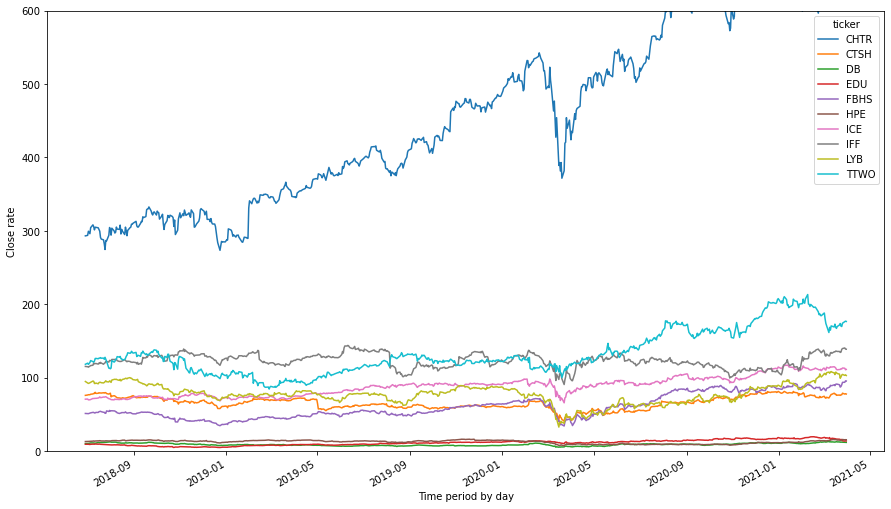

In [25]:
best_of_col_out = "bought_times"
top_stocks_by_top_funds,yf_df, graph = create_top_20_dfs(main_stock_df,best_of_col_out,cols_dict_top_20,"2018-06-30","2021-04-01", 600)

In [26]:
top_stocks_by_top_funds

,nameOfIssuer,titleOfClass,cusip,holding_duration,holding_proportion,portfolio_duration,Profit,yield_from_last_report,yield_from_1_year,yield_from_3_year,yield_from_continuous_profit,bought_times,ticker
0,FIAT CHRYSLER AUTOMOBILES N V,SHS,N31738102,6.125000,0.000260,0.001458,24.513958,-0.001458,0.0,0.0,0.0,31.000000,not_found
1,COGNIZANT TECHNOLOGY SOLUTIONS,CL A,192446102,4.625000,0.000119,0.000278,28.556667,0.020833,0.0,0.0,0.0,19.000000,CTSH
2,HEWLETT PACKARD ENTERPRISE CO,COM,42824C109,3.125000,0.000063,0.000000,-12.514583,0.219583,0.0,0.0,0.0,17.000000,HPE
3,CDN IMPERIAL BK COMM TORONTO O,COM,136069101,3.500000,0.000015,0.000000,-3.100000,-0.035185,0.0,0.0,0.0,16.000000,not_found
4,DEUTSCHE BANK AG,NAMEN AKT,D18190898,9.041667,0.000247,0.001864,-1004.526574,-4.671197,0.0,0.0,0.0,15.666667,DB
5,GOLDCORP INC NEW,COM,380956409,5.416667,0.000097,0.000000,167.871067,2.622978,0.0,0.0,0.0,15.666667,not_found
6,LYONDELLBASELL INDUSTRIES N V,SHS - A -,N53745100,3.750000,0.000072,0.000000,0.731379,-0.097586,0.0,0.0,0.0,15.000000,LYB
7,NEW ORIENTAL ED & TECH GRP INC,SPON ADR,647581107,3.125000,0.000042,0.000000,-2.090000,0.003333,0.0,0.0,0.0,15.000000,EDU
8,FIRST REP BK SAN FRANCISCO CAL,COM,33616C100,2.875000,0.000041,0.000000,19.029545,0.048182,0.0,0.0,0.0,15.000000,not_found
9,INTERNATIONAL FLAVORS&FRAGRANC,COM,459506101,2.750000,0.000029,0.000000,-22.826190,-0.041429,0.0,0.0,0.0,15.000000,IFF
